# 2D Membrane Study

To study membrane in 2D fashion we developed 3 classes `Cumulative2D`, `Voronoi2D`, and `PackingDefects`. The purpose of these classes is to facilitate the analysis of lipids membranes, particularly helping with two main problems:

- Some analyses are written for specific file extension, such as GROMACS, which complicates its wide usage. 
  
- Other analyses deal with properties only in one dimension (such as SCD). However, the lipid membrane is a highly complex environment and can have local changes afecting its properties and interactions with other biopolymers such as proteins or RNA. For instance, is well known that for phase transitions local properties change, as well as for lipid raft formations.

Here, we solve the first problem by using as base MDAnalysis, which is a widely used python library to study molecular dynamics systems. MDAnalysis allows to import files from different engines and process its information using widely know libraries such as numpy or pandas. This approach facilitates building pipelines for systems or automatize the analysis for various replicates. Here we focus primarily in membrane simulations that uses CHARMM forcefield, however some analysis can be adapted easily to other forcefields. We plan to include support for different force fields in the future. On the other hand, we used a two-dimensional approach, where the xy plane is divided into a 2D grid and the different properties are projected into it. This grid approach allows for easy visual inspections and comparison with different parts of the membrane. Some of the properties we included in this work are:


- Membrane thickness
- Order parameters
- Area per lipid with a voronoi approach
- Packing defects

- Lipid distribution (By using project_property method)
- Membrane charge (By using project_property method)

 Note that, in all cases but packing defects, several frames are considered in order to take averages over time. Likewise, each grid square contains the local time average of the property under study.  

## Cumulative2D

`Cumulative2D` helps to project membranes properties in a two dimensional fashion, on a plane perpendicular to the z axis.
This class uses the protocol showed in the image below. First, we divide the space in a grid $m\times m$ and
we collect the x, y positions of each individual lipid, as well as the property of interest (i.e. height) across :math:`n` frames. Then, we check which lipids belong
to each grid square using their x, y positions and finally, we take the average for each grid square. The output is
a matrix $m\times m$ and its edges in the shape $[x_{\text{min}},x_{\text{max}},y_{\text{min}}, y_{\text{max}}]$

![SCD comparison](../../docs/source/cumulative.png)

Import class

In [4]:

import MDAnalysis as mda
import numpy as np 
import matplotlib.pyplot as plt
from twodanalysis import Cumulative2D

The class `Cumulative2D` set up our membrane for analysis using MembProp, which does some guesses such as lipid chain length, the values max and min in the xy axis. Among others.

### Membrane thickness

Membrane thickness is the distance between the two leaflets of the lipid bilayer, computed from the lipid headgroup on one layer to the opossite. This property is influenced by several factors such as lipid compositions, cholesterol content, and temperature. This property is intimately related to membrane permeability, with a high thickness indicates low permeability. Furthermore, abnormalities in membrane thickness have been reported to be lated with diseases such as cancer and Alzheimer.

Here we present how to compute 2D membrane thickness using our code.

Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110


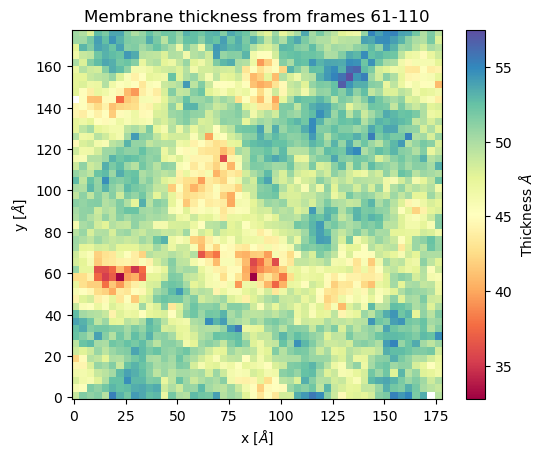

In [5]:
from twodanalysis import Cumulative2D
import numpy as np 
import matplotlib.pyplot as plt

# Import for MLKL membrane
top = "../../../../centered_prot.gro"
traj = "../../../../centered_prot.xtc"
tpr = "../../../../veamos.tpr"


# Data for RNA membrane
traj = "membrane.xtc"
tpr = "../data/veamos.tpr"



universe = mda.Universe(tpr,traj)
# Define a membrane object using a universe
membrane = Cumulative2D(universe,
                    verbose = False,nbins = 50)


# Compute the thickness of the membrane from frame 61 to frame 110, with 50 gridsquares. 
# Notice that as no edges are provided, the code uses the min and max values of the first frame. 
mat_thi, edges = membrane.thickness(nbins = 50,start = 61, final = 110, step = 1)



# Plor using imshow
plt.imshow(mat_thi, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Membrane thickness from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('Thickness $\AA$')


Let's walkthruogt the code:

The method `thickness(nbins, lipids, edges, start, final, step)` is applied to a membrane and their main parameters are:

- `nbins` : Set up the number of bins
- `lipids` : Account for the lipids in the membrane
- `edges` : edges for the grid we will be working in the shape [xmin,xmax,ymin,ymax]. If not provided we use the edges of the first frame using min and max positions of atoms
- `start` : Start frame
- `final` : Final frame
- `step` : Frames to skip

This method can be applied to the `Cumulative2D` object and the minimum it needs is nbins.

This code loops over frames, from `start` to `final` skiping `step` frames, and stores the xy positions of lipid heads. The positions are then used to compute the mean thickness of each grid square. This tool is useful to identify changes in membrane thickness over time, i.e., a protein changes it. Follows a comparison between different time periods, where we can see that they follows similar patters.


Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110
Computing matrix for top in frames 111-160
Computing matrix for bot in frames 111-160
<class 'numpy.ndarray'> True


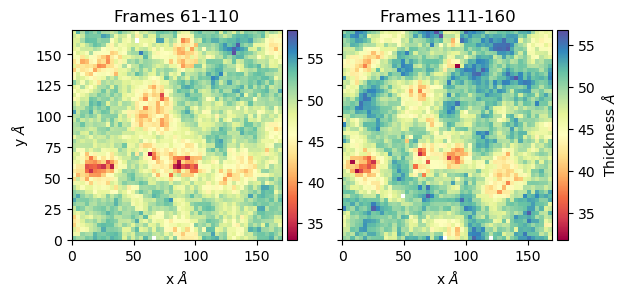

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Compute thickness for two frame/time intervals
mat_thi, edges = membrane.thickness(50, edges = [0,170,0,170],start = 61, final = 110, step = 1)
mat_thi_sec, edges = membrane.thickness(50, edges = [0,170,0,170],start = 111, final = 160, step = 1)





# Plot the resulting thickness
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(mat_thi, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Frames 61-110")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_thi_sec, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Frames 111-160")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('Thickness $\AA$')
print(type(mat_thi), isinstance(mat_thi, np.ndarray))


Follows a comparison between different time windows, where we can see that they do not follow similar patters anymore.

Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110
Computing matrix for top in frames 461-510
Computing matrix for bot in frames 461-510


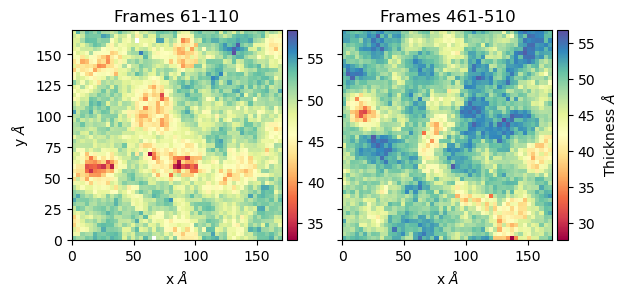

In [7]:


mat_thi, edges = membrane.thickness(50, edges = [0,170,0,170],start = 61, final = 110, step = 1)
mat_thi_sec, edges = membrane.thickness(50, edges = [0,170,0,170],start = 461, final = 510, step = 1)

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(mat_thi, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Frames 61-110")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_thi_sec, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Frames 461-510")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('Thickness $\AA$')

Notice that this code does not account for CHL, if you want to consider it you should pass the lispid list specifically as follows.

Lipids taken into account ['POPE', 'DSPC', 'DODMA', 'CHL1']
Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110
Computing matrix for top in frames 461-510
Computing matrix for bot in frames 461-510


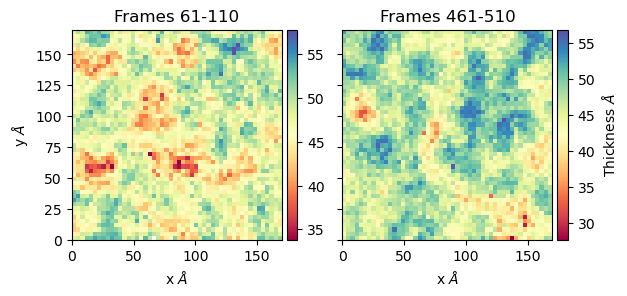

In [8]:

lipid_list = list(membrane.lipid_list)
print(f"Lipids taken into account {lipid_list}")

# compute thickness with specific lipids
mat_thi, edges = membrane.thickness(50, lipid_list = lipid_list, edges = [0,170,0,170],start = 61, final = 110, step = 1)
mat_thi_sec, edges = membrane.thickness(50,  lipid_list = lipid_list, edges = [0,170,0,170],start = 461, final = 510, step = 1)


# Plot results
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(mat_thi, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Frames 61-110")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_thi_sec, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Frames 461-510")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('Thickness $\AA$')

To compute the thickness we consided the P carbon of the phospholipids and the O3' atom of the CHL1, if you need to change this behaviour you should update the dictionary `membrane.working_lip[lipid][head]`. For example


In [9]:

membrane.working_lip["CHL1"]["head"] = "C9"

This will change the plots as follows

Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110
Computing matrix for top in frames 461-510
Computing matrix for bot in frames 461-510


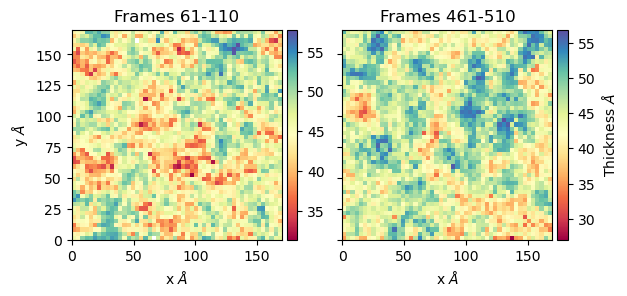

In [10]:

lipid_list = list(membrane.lipid_list)

# Compute thickness acounting C9 atom fro CHL1
mat_thi, edges = membrane.thickness(50, lipid_list = lipid_list, edges = [0,170,0,170],start = 61, final = 110, step = 1)
mat_thi_sec, edges = membrane.thickness(50,  lipid_list = lipid_list, edges = [0,170,0,170],start = 461, final = 510, step = 1)




# Plot results
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(mat_thi, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Frames 61-110")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_thi_sec, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Frames 461-510")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('Thickness $\AA$')

We can also compute the thickness using the center of mass of several atoms in the lipid head. As before, you should specify what atoms will be considered. For example:

['POPE', 'DSPC', 'DODMA', 'CHL1']
Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110
Computing matrix for top in frames 461-510
Computing matrix for bot in frames 461-510


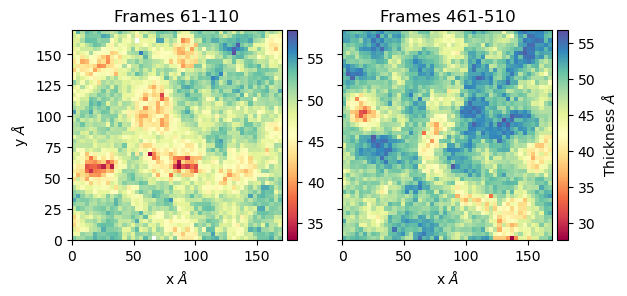

In [11]:
# Return CHL1 to its original atom
membrane.working_lip["CHL1"]["head"] = "O3"
print(membrane.lipid_list)

# Use other atoms for POPE
membrane.working_lip["POPE"]["head"] = ["P", "O13", "O14", "O11", "O12"]


# Compute thickness ingnoring CHL1 and using ["P", "O13", "O14", "O11", "O12"] COM for POPE
mat_thi, edges = membrane.thickness(50, edges = [0,170,0,170],start = 61, final = 110, step = 1)
mat_thi_sec, edges = membrane.thickness(50,  edges = [0,170,0,170],start = 461, final = 510, step = 1)



# Plot results
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(mat_thi, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Frames 61-110")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_thi_sec, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Frames 461-510")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('Thickness $\AA$')

`thickness` call a method called `height_matrix`, this function computes the distance from the middle of the membrane (height) projected in a 2D grid. Thus, calling `height_matrix` for each layer and adding the results ends with membrane thickness. The user can compute the height matrix as follows.

 lipids to be used in this code  ['POPE', 'DSPC', 'DODMA']
Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110


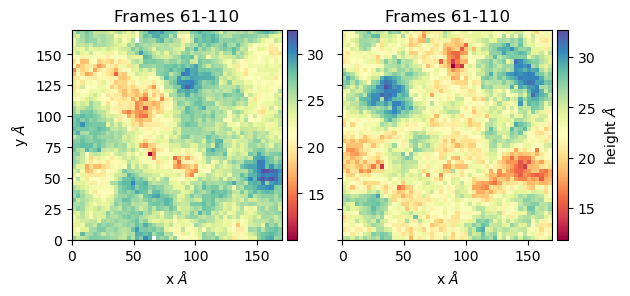

In [12]:

lipids = list(membrane.lipid_list)
lipids.remove("CHL1")
print(f" lipids to be used in this code  {lipids}")

# Return to the use of P for POPE
membrane.working_lip["POPE"]["head"] = "P"

# Compute the height of the monolayers top/bot form the mid of the membrane
mat_top, edges = membrane.height_matrix(lipid_list=lipids, layer = "top", nbins = 50, edges = [0,170,0,170],start = 61, final = 110, step = 1)
mat_bot, edges = membrane.height_matrix(lipid_list=lipid_list, layer = "bot", nbins = 50, edges = [0,170,0,170],start = 61, final = 110, step = 1)

fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(mat_top, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Frames 61-110")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_bot, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Frames 61-110")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('height $\AA$')


Computing matrix for top in frames 61-110
Computing matrix for bot in frames 61-110


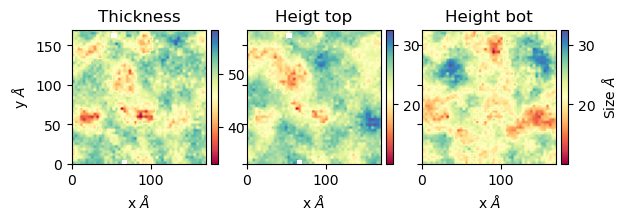

In [13]:
# Plot for both heights and the thickness

mat_thi, edges = membrane.thickness(50, edges = [0,170,0,170],start = 61, final = 110, step = 1)

fig, ax = plt.subplots(1,3, sharex = True, sharey = True)
first = ax[0].imshow(mat_thi, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Thickness")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)


second = ax[1].imshow(mat_top, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Heigt top")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)


third = ax[2].imshow(mat_bot, extent=edges, cmap="Spectral")
ax[2].set_xlabel("x $\AA$")
ax[2].set_title("Height bot")
divider2 = make_axes_locatable(ax[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)

cbar.set_label('Size $\AA$')




### Order parameters (SCD)

When studying a membrane one of the most important properties is the order parameters SCD. This property measure the order of the lipids within the membrane and provide crucial insights intro the structural and dynamic properties of the bilayer. SCD can be determined experimentally and computationally turning them into the comparison point between both kind of studies. For all-atom molecular dynamics simulations, SCD for the $i-th$ carbon is computed with the following equation

$$ SCD_i = \left| \braket{\frac{3cos^2(\theta_i)}{2} - \frac{1}{2}}\right|, $$

where $\theta_i$ is the angle between the $i-th$ carbon and its hydrogens. Notice that this quantity is averaged over lipids and over time, as well as its absolute value is taken into account.

#### 2D order parameters

Given that order parameters provide valuable structural and dynamical information and that the membrane is a highly complex system where the properties can change from point to point, we provide a way to compute SCD in a 2D fashion, averaged in time for each grid square. Here, the positions of the lipids is tracked for several frames and mapped to a 2D grid build by user specifications. Then, for each grid square, for each lipid specie, for each tail, the SCD is computed. Likewise, we compute the SCD average of the lipid tails and finally average over lipid species. The final result is a 2D grid matrix containing averaged SCD over a short period of time. 

The method described above is part of Cumulative2D as can be used as follows:

POPE
DSPC
DODMA


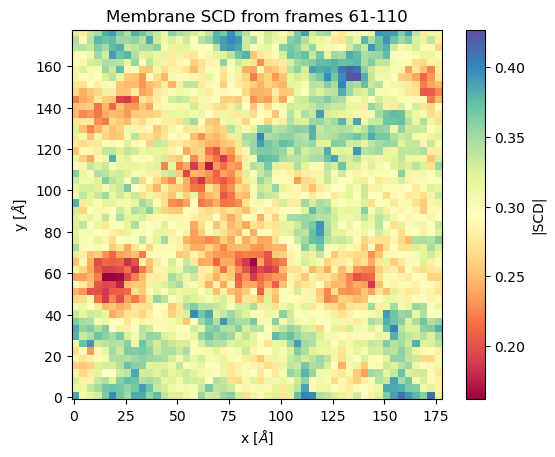

In [14]:
scd, edges = membrane.all_lip_order(layer = "both", start = 61, final = 110)

plt.imshow(scd, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Membrane SCD from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('|SCD|')


User can also compute the order parameters for only one layer as follows:

POPE
DSPC
DODMA
POPE
DSPC
DODMA


/home/ricard/Documents/development/twod-analysis-kit/twodanalysis/Cumulative2D.py:398: RuntimeWarning: Mean of empty slice
  matrices = np.nanmean(matrices, axis = 0)


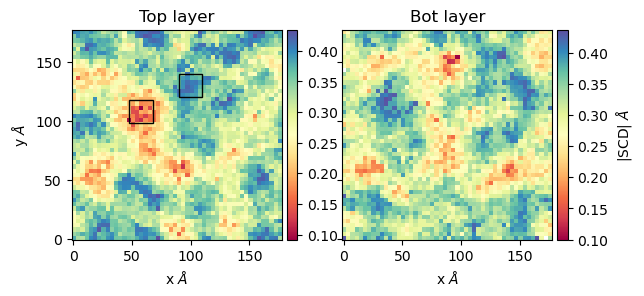

In [15]:
import matplotlib.patches as patches

# Compute average order parameters layers for each grid squate over 61 to 110 frames 
scd_top, edges = membrane.all_lip_order("top", 50, start = 61, final=110, step = 1)
scd_bot, edges = membrane.all_lip_order("bot", 50, start = 61, final=110, step = 1)




# Plot 
fig, ax = plt.subplots(1,2, sharex = True, sharey = True)
first = ax[0].imshow(scd_top, extent=edges, cmap="Spectral")
ax[0].set_xlabel("x $\AA$")
ax[0].set_ylabel("y $\AA$")
ax[0].set_title("Top layer")
divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(first, cax = cax1)
# Point to a low ordered region
ax[0].add_patch(patches.Rectangle((48, 98), 20,20, linewidth = 1, edgecolor = "black", facecolor = "none"))
ax[0].add_patch(patches.Rectangle((90, 120), 20,20, linewidth = 1, edgecolor = "black", facecolor = "none"))



second = ax[1].imshow(scd_bot, extent=edges, cmap="Spectral")
ax[1].set_xlabel("x $\AA$")
ax[1].set_title("Bot layer")
divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(second, cax = cax2)
cbar.set_label('|SCD| $\AA$')


We highlighted two regions on the top layer plot. These regions correspond to a low ordered region and a high ordered region that are easily computed with our toolkit. Follows a VMD plot for the lipids in the underlined regions in licorice representation and no hydrogens, where the lipids clearly show different order as our code suggest. Interestingly, the disordered regions implies a disorder in all lipids and not those known to be more disordered such as DODMA, same is true viceversa.
 
![SCD comparison](../../docs/source/image1aa.png)

Our code also allows for computing the SCD grid for individual lipids and this is done as follows:

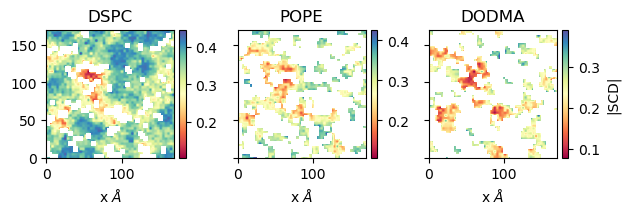

In [16]:
# Get the chains for each lipid
n_chain = membrane.chain_info

lipids = ["DSPC", "POPE", "DODMA"]

# Compute average order parameters layers for each grid squate over 61 to 110 frames
scd_matrices = {}
for lipid in lipids: 
    scd_top, edges = membrane.order_matrix(lipid, "top",edges = [0,170,0,170], nbins= 50, n_chain = n_chain[lipid],start = 61, final=110, step = 1)
    scd_matrices[lipid] = scd_top




# Plot 
fig, ax = plt.subplots(1,len(lipids), sharex = True, sharey = True)
for i, lipid in enumerate(lipids):
    plot = ax[i].imshow(scd_matrices[lipid], extent=edges, cmap="Spectral")
    ax[i].set_xlabel("x $\AA$")
    ax[i].set_title(f"{lipid}")
    divider1 = make_axes_locatable(ax[i])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(plot, cax = cax1)
cbar.set_label('|SCD|')
plt.tight_layout()


This shows the distribution of lipids and its Order parameter value. 

Notice that the code guesses chain lenght, and diferentiate between chain lenghts based on the names the forcefield assign to lipid tails. For chain sn1 the the $ith$ carbon has the shape $C3i$, whereas the hydrogens can be $HiX$, $HiY$, and $HiZ$. On the other hand, for sn2 the $ith$ carbon has the shape $C2i$ and, similarly, the hydrogens can be $HiR$, $HiS$, and $HiT$. If you are using a forcefield different than CHARMM you may have to take this into account. In the future we will change the selections in order to automatically support other forcefileds.

### Other properties

Until now, we have explored thickness, height, and order parameters. However, `Cumulative2D` allows to project other properties. For instance splay angle, that can be called as follows. Here Splay angle is defined as the angle between the P atom and the last carbon of the lipid tail.



Computing matrix for top in frames 61-110


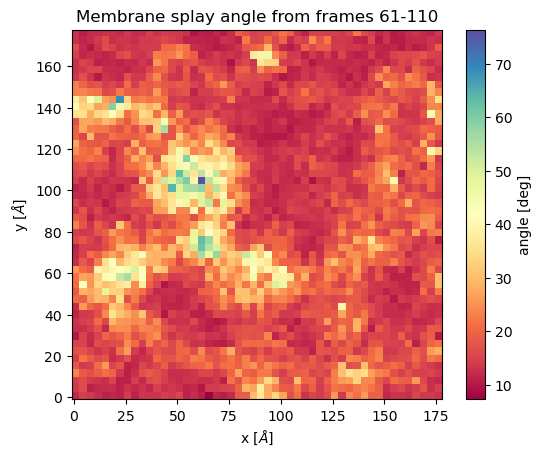

In [17]:
lipid_list = list(membrane.lipid_list)
lipid_list.remove("CHL1")
splay, edges = membrane.splay_matrix(lipid_list=lipid_list,
                                     layer = "top",
                                     start = 61,
                                     final=110)


plt.imshow(splay, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Membrane splay angle from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('angle [deg]')

To plot properties different that the ones previously adressed, you should create a function that takes and atomgroup and returns two arrays, one with the ids, and the other with the values of the property you aim to compute. As an example, here we will assign random charge value to each lipid and project the average charge.

Computing matrix for top in frames 61-110
We passed


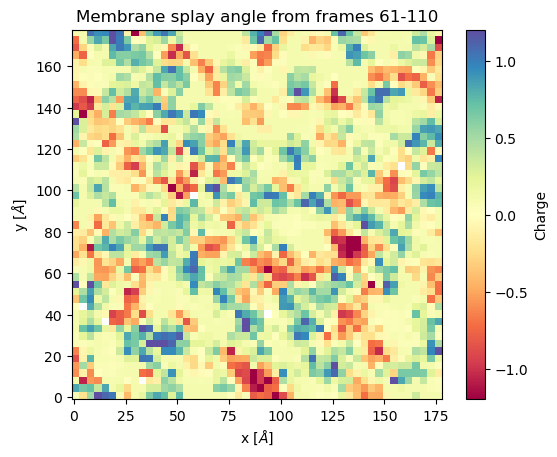

In [18]:

# Define functions to map charges
def map_charges(atomgroup):
    dict_charge = {
        "DODMA" : -1.2,
        "DSPC" : 0.1,
        "CHL1" : 0,
        "POPE" : 1.2,
    }
    ids = atomgroup.residues.resids

    charges = [dict_charge[lipid] for lipid in atomgroup.residues.resnames]    
    charges = np.array(charges)

    return ids, charges


# Project property

charges_m, edges = membrane.project_property(map_charges, layer = "top", start=61, final = 110)
plt.imshow(charges_m, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Membrane splay angle from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('Charge')

Our code also allows to plot distribution of lipids over some period of time. If you want to do this, you can map the values of the lipid you are interested to 1 and the other to np.nan. Also, you should activate the flag distribution = True, as follows:

Computing matrix for top in frames 61-110
We passed


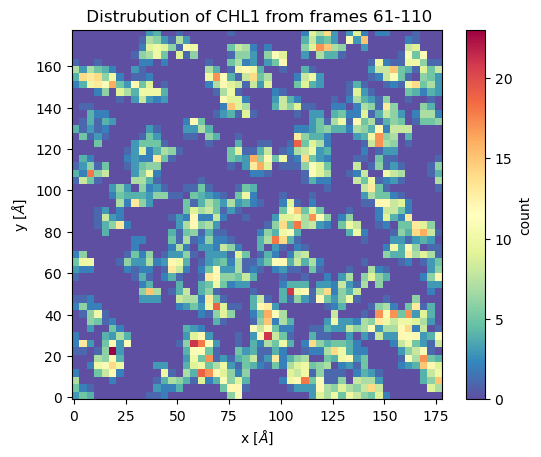

In [19]:

# Define functions to map charges
def map_distrib(atomgroup):
    dict_charge = {
        "DODMA" : 0,
        "DSPC" : 0,
        "CHL1" : 1,
        "POPE" : 0,
    }
    ids = atomgroup.residues.resids

    charges = [dict_charge[lipid] for lipid in atomgroup.residues.resnames]    
    charges = np.array(charges)

    return ids, charges


# Project property

charges_m, edges = membrane.project_property(map_distrib, layer = "top", distribution=True,start=61, final = 110)
plt.imshow(charges_m, extent=edges, cmap="Spectral_r")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title(" Distrubution of CHL1 from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('count')

Red regions are enriched in cholesterol

We conclude this tutorial by mentioning that any property can be projected to the 2D plane,as a long as you can create a the function mentioned before. Some ideas onto what to project include charge, tilt angle, velocities, forces (can be imported using xvg files if they are not yet there).

## PackingDefects class

Packing defects measure the exposure of the hydrophobic core in lipid membranes. For this analysis, we have based our code in https://doi.org/10.1016/j.bpj.2018.06.025, that used a grid approach where they project hydrophobic and hydrophilic atoms in the grid. Here, the grid spaces with none or only hydrophobic atoms correspond to packing defects and the area is computed. We took a similar approach but include support for periodicity, optimize the computations, and accept various format files, opposite to packmem that only accepts pdb files.

Packmem needs two main things (i) the radius of each atom (i) a file that splits the hydrophilic and hydrophobic atoms. PackingDefects includes standard atoms sizes for H, N, C, P, and O specified in `self.radii_dict`. Packing defects is able to guess the hydrophobicity based on the bonds of the two hydrophobic chains which can be provided in the initialization, but as they are standard for most lipids you do not need to add it unless you are working with a special lipid. To asure that the atoms you want to consider for hydrophobicity we strongly suggest to visually inspect which atoms correspond to the hydrophobic ones with `self.visualize_polarity`. 

Thus, we have been able to automatize the computation of packing defects and, at the same time, allows to use different trajectories and topology files as input.

`PackingDefects.packing_defects` is a method that can be applied to a PackingDefects object, it has all values as default, however you can change the behaviour of all of them. This parameters include `layer`, `nbins`, `edges`, `periodic`, among others. The difference between this analysis and the previous ones is that it is done per frame, and does not account for several data accumulation. Thus, the return is a 2D grid per each frame and a dictionary that contains information about packing defects. Follows an example. 

Before running packing defects we strongly recommend to visualize the polarity of the lipids since, currently, sometimes, our code wrongly assign double bonds in the lipids tail as hydrophilic. 

In [20]:
from twodanalysis import PackingDefects
import MDAnalysis as mda
# Data for RNA membrane
traj = "membrane.xtc"
tpr = "../data/veamos.tpr"
universe = mda.Universe(tpr,traj)
membrane = PackingDefects(universe)

POPE : {'N', 'C12', 'O21', 'HY', 'HN2', 'HN1', 'HS', 'HB', 'O14', 'HX', 'O12', 'H12B', 'O11', 'C11', 'HN3', 'C21', 'P', 'O31', 'O32', 'HA', 'O22', 'C31', 'H12A', 'C3', 'O13', 'C2', 'H11A', 'C1', 'H11B'}
DSPC : {'N', 'C12', 'O21', 'H13A', 'HY', 'H15A', 'HS', 'HB', 'O14', 'C14', 'HX', 'H15C', 'O12', 'H14A', 'H12B', 'O11', 'H14B', 'C11', 'C13', 'C21', 'P', 'O31', 'O32', 'HA', 'H14C', 'O22', 'H13C', 'H13B', 'C15', 'C1', 'C31', 'C3', 'O13', 'C2', 'H11A', 'H12A', 'H11B', 'H15B'}
DODMA : {'H1Y', 'H11', 'HN22', 'N1', 'O21', 'HN21', 'HY', 'HN23', 'H1R', 'HN12', 'H1S', 'HS', 'H12', 'CN2', 'HX', 'C21', 'O31', 'H1X', 'C31', 'HN11', 'CN1', 'C3', 'HN13', 'C2', 'C1'}
[{'C8', 'H1A', 'C10', 'C6', 'H18B', 'H21B', 'H26C', 'C12', 'H27B', 'H14', 'H8', 'H21A', 'H3', 'C23', 'H20', 'C26', 'C7', 'H15A', 'H2B', 'H17', 'H27C', 'C16', 'C5', 'H16B', 'C24', 'C25', 'H18C', 'H16A', 'C14', 'H26A', 'H22A', 'H4B', 'H23B', 'H7A', 'H12B', 'H27A', 'C11', 'C4', 'C13', 'C18', 'H6', 'H22B', 'C17', 'C21', 'H21C', 'H24A', 'C19'

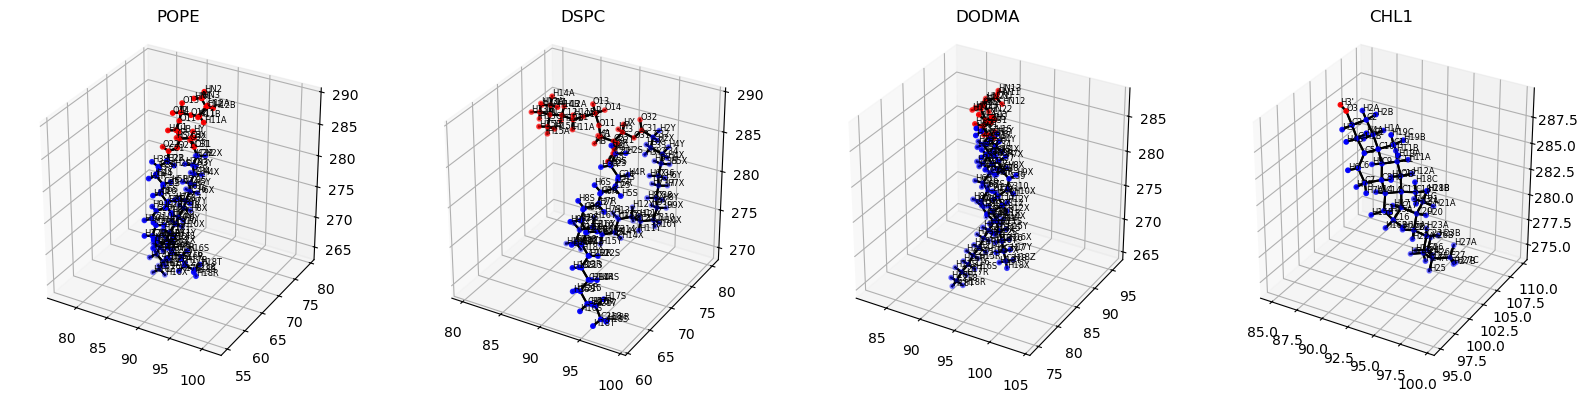

In [21]:
# Check polarity

membrane.visualize_polarity()


Notice that you can customize where to start the hydrophobic atoms by providing connection_chains. By default, connection chains uses:
[("O3", "C3")] for CHL1 which implies a connection for CHL1 in the atoms O3-C3, and [("C21", "C22"), ("C31", "C32")] for other lipids which implies a connection in the atoms C21-C22 (sn2) and C31-C32 (sn1). You can actually provide any bond that splits the lipid in two as the previous ones does. For instance, lets try with different bonds. Here we will use C21-C22 and C31-C32 for DODMA, C23-C24 and C33-C34 for POPE, C25-C26 and C37-C38 for DSPC and  C5-C6 for CHL1.


POPE : {'N', 'C12', 'O21', 'HY', 'C23', 'H3Y', 'HN2', 'HN1', 'HS', 'H3S', 'HB', 'C32', 'H3X', 'O14', 'H3R', 'HX', 'O12', 'H2R', 'H12B', 'O11', 'C11', 'C33', 'HN3', 'C21', 'H2Y', 'H2S', 'P', 'O31', 'O32', 'HA', 'O22', 'H2X', 'C31', 'H12A', 'C22', 'C3', 'O13', 'C2', 'H11A', 'C1', 'H11B'}
DSPC : {'H7X', 'N', 'C12', 'O21', 'H13A', 'H6Y', 'C37', 'HY', 'C23', 'H3Y', 'C34', 'H15A', 'H4Y', 'HS', 'H6X', 'H3S', 'HB', 'C32', 'C24', 'H3X', 'O14', 'C25', 'H5R', 'H5Y', 'H3R', 'C14', 'H4S', 'HX', 'H4R', 'C36', 'H15C', 'O12', 'H2R', 'H14A', 'H12B', 'O11', 'H14B', 'C11', 'C13', 'C35', 'C33', 'C21', 'H4X', 'H2Y', 'H5X', 'H2S', 'P', 'O31', 'O32', 'HA', 'H14C', 'H5S', 'O22', 'H7Y', 'H13C', 'H2X', 'H13B', 'C15', 'C1', 'C31', 'C22', 'C3', 'O13', 'C2', 'H11A', 'H12A', 'H11B', 'H15B'}
DODMA : {'H1Y', 'H11', 'HN22', 'N1', 'O21', 'HN21', 'HY', 'HN23', 'H1R', 'HN12', 'H1S', 'HS', 'H12', 'CN2', 'HX', 'C21', 'O31', 'H1X', 'C31', 'HN11', 'CN1', 'C3', 'HN13', 'C2', 'C1'}
[{'C8', 'H1A', 'C10', 'C6', 'H18B', 'H21B', "

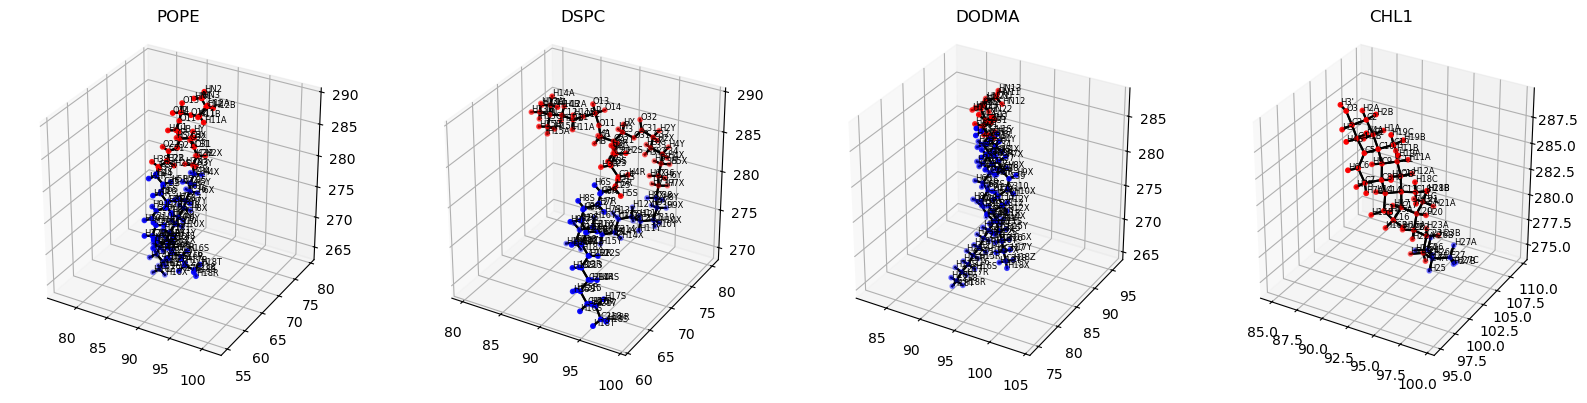

In [22]:
# Check polarity
import matplotlib.pyplot as plt
%matplotlib inline

connection_chains = {"CHL1" : [("C24", "C25")],
                    "DODMA" : [("C21", "C22"), ("C31", "C32")],
                    "POPE" : [("C23", "C24"), ("C33", "C34")],
                    "DSPC" : [("C25", "C26"), ("C37", "C38")],

                    
                    
                    }
membrane = PackingDefects(universe=universe,connection_chains=connection_chains)
membrane.visualize_polarity()
plt.show()


Now, after checking the correct assign for hydrophobic atoms, we are ready to run packing defects. You can run packing deffects for any squared grid, i.e., a grid with the same distance in x and y. 


POPI1 : {'O6', 'C12', 'O21', 'H4', 'H5', 'H2', 'HY', 'H3', 'HO6', 'HO4', 'HO2', 'HS', 'O5', 'HO3', 'HB', 'C16', 'OP53', 'O14', 'C14', 'HX', 'O12', 'O11', 'C11', 'C13', 'H6', 'C21', 'H1', 'OP52', 'P', 'O31', 'O32', 'HA', 'O22', 'C15', 'O4', 'C31', 'O2', 'P5', 'O3', 'C3', 'O13', 'C2', 'C1', 'OP54'}
[{'C8', 'H1A', 'C10', 'C6', 'H18B', 'H21B', 'H26C', 'C12', 'H27B', 'H14', 'H8', 'H21A', 'H3', 'C23', 'H20', 'C26', 'C7', 'H15A', 'H2B', 'H17', 'H27C', 'C16', 'C5', 'H16B', 'C24', 'C25', 'H18C', 'H16A', 'C14', 'H26A', 'H22A', 'H4B', 'H23B', 'H7A', 'H12B', 'H27A', 'C11', 'C4', 'C13', 'C18', 'H6', 'H22B', 'C17', 'C21', 'H21C', 'H24A', 'C19', 'H19B', 'H9', 'H19A', 'H26B', 'C9', 'C20', 'H25', 'C15', 'H19C', 'H4A', 'H1B', 'H18A', 'H12A', 'C22', 'C3', 'H23A', 'C2', 'H2A', 'H11A', 'C27', 'H7B', 'C1', 'H11B', 'H15B', 'H24B'}, {"H3'", 'O3'}] {'C8', 'H1A', 'C10', 'C6', 'H18B', 'H21B', 'H26C', 'C12', 'H27B', 'H14', 'H8', 'H21A', 'H3', 'C23', 'H20', 'C26', 'C7', 'H15A', 'H2B', 'H17', 'H27C', 'C16', 'C5', '

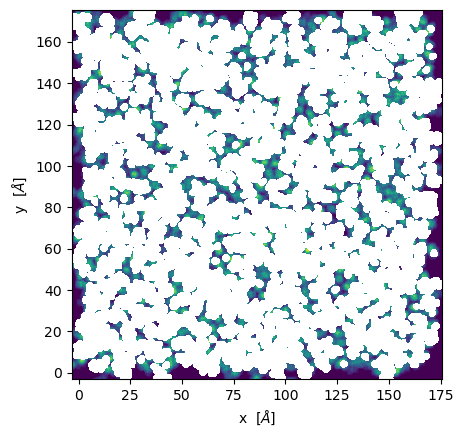

In [23]:
# Compute deffects for the 100 frame
import MDAnalysis as mda
from twodanalysis import PackingDefects
import matplotlib.pyplot as plt

top = "../../../../centered_prot.gro"
traj = "../../../../centered_prot.xtc"
tpr = "../../../../veamos.tpr"


universe = mda.Universe(top,traj)
membrane= PackingDefects(universe)
membrane.u.trajectory[100]
defects, defects_dict = membrane.packing_defects(layer = "top", nbins = 400)


plt.imshow(defects, cmap = "viridis", extent = defects_dict["edges"])
plt.xlabel("x  $[\AA]$")
plt.ylabel("y  $[\AA]$")
plt.show()



POPI1 : {'O6', 'C12', 'O21', 'H4', 'H5', 'H2', 'HY', 'H3', 'HO6', 'HO4', 'HO2', 'HS', 'O5', 'HO3', 'HB', 'C16', 'OP53', 'O14', 'C14', 'HX', 'O12', 'O11', 'C11', 'C13', 'H6', 'C21', 'H1', 'OP52', 'P', 'O31', 'O32', 'HA', 'O22', 'C15', 'O4', 'C31', 'O2', 'P5', 'O3', 'C3', 'O13', 'C2', 'C1', 'OP54'}
[{'C8', 'H1A', 'C10', 'C6', 'H18B', 'H21B', 'H26C', 'C12', 'H27B', 'H14', 'H8', 'H21A', 'H3', 'C23', 'H20', 'C26', 'C7', 'H15A', 'H2B', 'H17', 'H27C', 'C16', 'C5', 'H16B', 'C24', 'C25', 'H18C', 'H16A', 'C14', 'H26A', 'H22A', 'H4B', 'H23B', 'H7A', 'H12B', 'H27A', 'C11', 'C4', 'C13', 'C18', 'H6', 'H22B', 'C17', 'C21', 'H21C', 'H24A', 'C19', 'H19B', 'H9', 'H19A', 'H26B', 'C9', 'C20', 'H25', 'C15', 'H19C', 'H4A', 'H1B', 'H18A', 'H12A', 'C22', 'C3', 'H23A', 'C2', 'H2A', 'H11A', 'C27', 'H7B', 'C1', 'H11B', 'H15B', 'H24B'}, {"H3'", 'O3'}] {'C8', 'H1A', 'C10', 'C6', 'H18B', 'H21B', 'H26C', 'C12', 'H27B', 'H14', 'H8', 'H21A', 'H3', 'C23', 'H20', 'C26', 'C7', 'H15A', 'H2B', 'H17', 'H27C', 'C16', 'C5', '

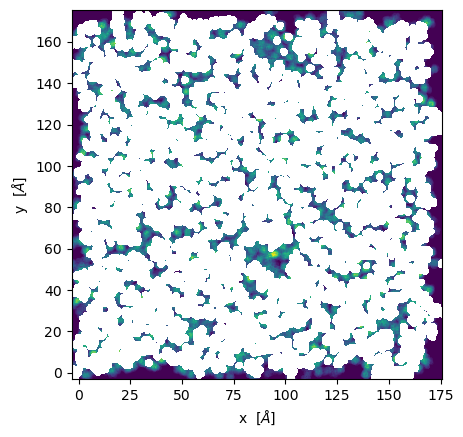

In [24]:
# Compute deffects for the 1236 frame
import MDAnalysis as mda
from twodanalysis import PackingDefects
import matplotlib.pyplot as plt
import numpy as np
top = "../../../../centered_prot.gro"
traj = "../../../../centered_prot.xtc"
tpr = "../../../../veamos.tpr"


universe = mda.Universe(top,traj)
membrane= PackingDefects(universe)
membrane.u.trajectory[1236]

defects, defects_dict = membrane.packing_defects(layer = "bot", nbins = 400)
#defects = np.fliplr(defects)


# Plot defects
plt.close()

plt.imshow(defects, cmap = "viridis", extent = defects_dict["edges"])
plt.xlabel("x  $[\AA]$")
plt.ylabel("y  $[\AA]$")
plt.show()

We did not address the deepness of the packing defects. However, we stored a related quantity which is the density of hydrophobic atoms below a packing defect. This is the value presented in the palette. There is a proportionality between the deepness of the packing defect and the deepness since the regions with no density does not have atoms at all which mean that the deepness of that packing defects is the height of the layer.  

The latter run did not account for periodicity, which may turn into a problem when computing packing defects for areas with a side larger than the periodic box. If you want that to take into account periodicity, you should specify it by adding `periodic = True`. In this case, you do not have to provide the edges and the matrix returned is of the size of the periodic box.

edges : [-3.21, 166.94461391448976, -3.21, 166.94461391448976]
area : {'defects': 7327.6520645713035, 'total': 28952.592649370836}
count : {'number': 272, 'sizes': array([2394,    6,  657,    3, 2251,   37,  713,   76,  220,  160,    2,
          2,    1,    2,    1,    1,    1, 2299,    1,   28,    1,    4,
          6,    1,    9,    3,    3,   22,   41,   92,    1,    3,  352,
          5,    1,  314,   15,    2,    2,    3,   41,    3,    1,   45,
          1, 1943,    9,    2,    1,    1,    3,   69,    4,   73,    1,
          7,   18,   25,   49,   10,    1,    1,    2,    1,    1,   44,
          2,    1, 5622,    7,   59,  459,    1,    4,    6,  737,    2,
          1,   86,  149,    3,   85,    1,    1,    2,    1,    6,  221,
        288,    2,    7,   43,  184,   31,    1,    3,   50,   72,   32,
         29,    7,   56,  122,    3,   15,   13,    5,    6, 1656,    7,
         52,    4,  251,  489,    2,    1,   46,    8,   22,  335,    2,
          1,    1,    1,   25,   

Text(0, 0.5, 'y  $[\\AA]$')

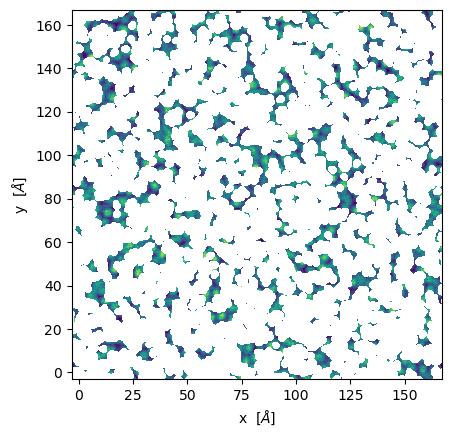

In [25]:
# Compute deffects for the first frame
defects, defects_dict = membrane.packing_defects(layer = "top", nbins = 400, periodic=True)


# Print dictionary

print(membrane.print_dict(defects_dict))

# Plot defects
plt.imshow(defects, cmap = "viridis", extent = defects_dict["edges"])
plt.xlabel("x  $[\AA]$")
plt.ylabel("y  $[\AA]$")


Next, we plot the probability of defects of having a specific area. For this, we used the sizes of all the defects found, which is stored in the returned dictionary.

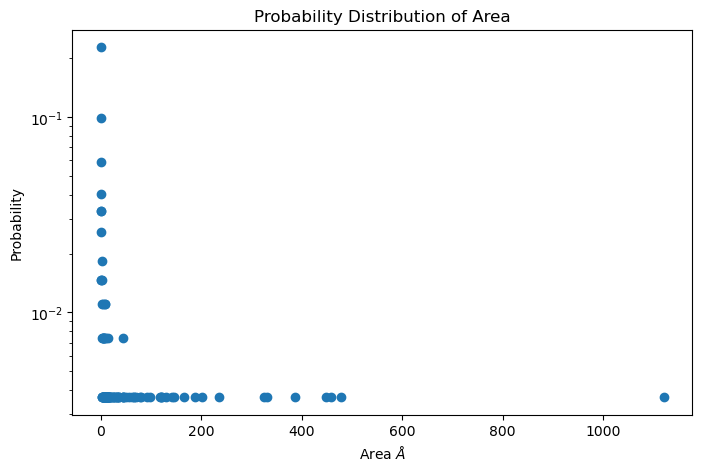

In [26]:
import numpy as np
data = defects_dict["count"]["sizes"]

unique, counts = np.unique(data, return_counts = True)
probabilities = counts/counts.sum()

plt.figure(figsize=(8, 5))
plt.scatter(unique*defects_dict["grid_size"]*defects_dict["grid_size"], probabilities)
plt.xlabel('Area $\AA$')
plt.yscale('log')
plt.ylabel('Probability')
plt.title('Probability Distribution of Area')
plt.show()


Now, we can use `packing_defects_stats` to compute properties over time


In [27]:
membrane.verbose = True
defects_df, numpy_sizes = membrane.packing_defects_stats(nbins = 400,
                                                      layer = "top",
                                                      edges=[75,115,40,80],
                                                      start = 61,
                                                      final = 2000,
                                                      step=10)


In [28]:
defects_df.tail(5)

,defects_area,total_area,n_defects
189,476.86,1600.0,30
190,532.62,1600.0,25
191,480.82,1600.0,22
192,475.43,1600.0,27
193,449.52,1600.0,19


Now we can plot the percentage of packing defects over time

Text(0, 0.5, 'Percentage of packing deffetcs')

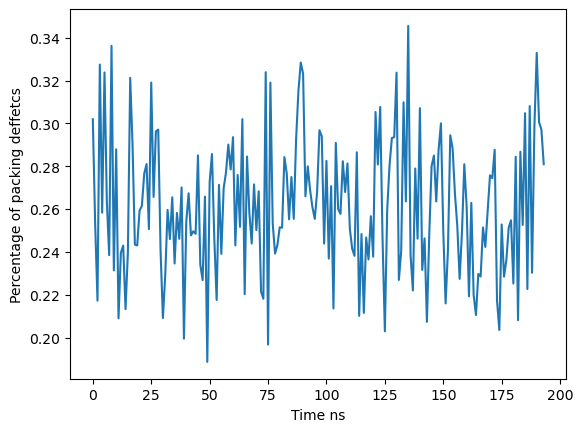

In [29]:
plt.plot(defects_df["defects_area"]/defects_df["total_area"])
plt.xlabel("Time ns")
plt.ylabel("Percentage of packing deffetcs")

Text(0, 0.5, 'Percentage of packing deffetcs')

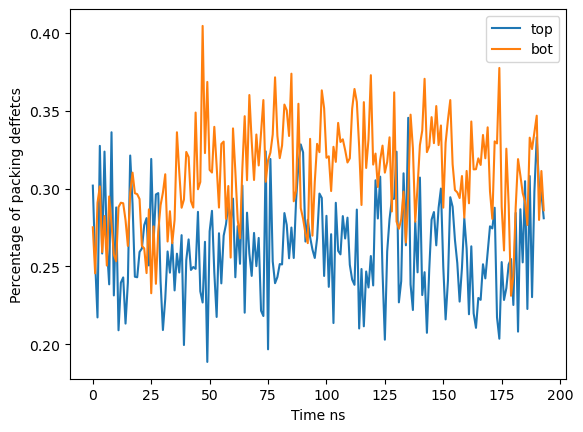

In [30]:
defects_bot, numpy_sizes = membrane.packing_defects_stats(nbins = 400,
                                                      layer = "bot",
                                                      edges=[75,115,40,80],
                                                      start = 61,
                                                      final = 2000,
                                                      step=10)

plt.plot(defects_df["defects_area"]/defects_df["total_area"], label = "top")
plt.plot(defects_bot["defects_area"]/defects_bot["total_area"], label = "bot")
plt.legend()
plt.xlabel("Time ns")
plt.ylabel("Percentage of packing deffetcs")

Here we compare two boxes of the same size. One in the top layer and the other in the bottom layer. Notice that packing defects are bigger in one and this is due to a protein interacting in the bottom layer.

Text(0, 0.5, 'Percentage of packing deffetcs')

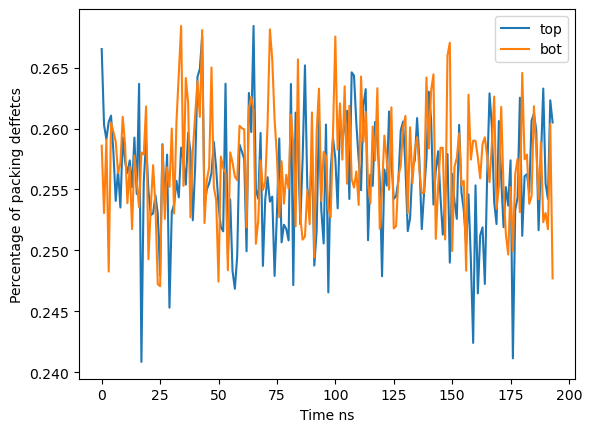

In [31]:
defects_bot, numpy_sizes = membrane.packing_defects_stats(nbins = 400,
                                                      layer = "bot",
                                                      periodic=True,
                                                      start = 61,
                                                      final = 2000,
                                                      step=10)

defects_df, numpy_sizes = membrane.packing_defects_stats(nbins = 400,
                                                      layer = "top",
                                                      periodic=True,
                                                      start = 61,
                                                      final = 2000,
                                                      step=10)

plt.plot(defects_df["defects_area"]/defects_df["total_area"], label = "top")
plt.plot(defects_bot["defects_area"]/defects_bot["total_area"], label = "bot")
plt.legend()
plt.xlabel("Time ns")
plt.ylabel("Percentage of packing deffetcs")

We can also compute the probability of the size of the packing defects

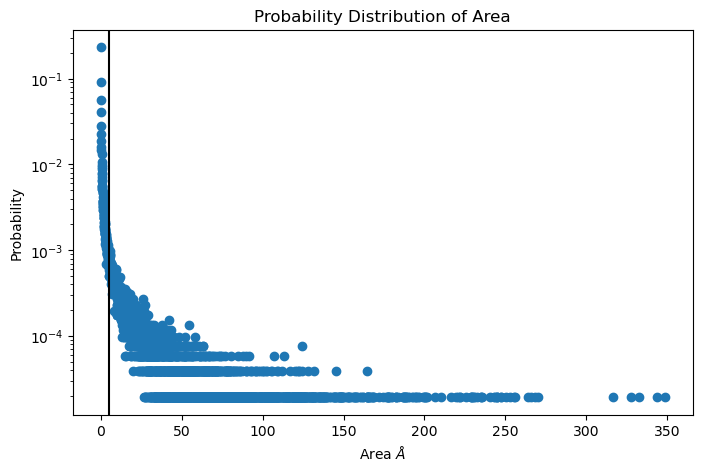

In [32]:

unique, counts = np.unique(numpy_sizes, return_counts = True)
probabilities = counts/counts.sum()

plt.figure(figsize=(8, 5))
plt.scatter(unique*defects_dict["grid_size"]*defects_dict["grid_size"], probabilities)
plt.xlabel('Area $\AA$')
plt.yscale('log')
plt.ylabel('Probability')
plt.title('Probability Distribution of Area')
plt.axvline(x = 5, color = "black")
plt.show()

## Voronoi2D

Voronoi2D is a class that builds a voronoi diagram using the x and y positions of lipids and maps it to a 2D grid. The map can assign each voronoi cell with a particular value, which is what we call project values within the voronoi approach. The final step to project a property includes iterate over frames and obtain an average of the frames. Properties that are already included to project in the code are thickness, APL, splay angle. Furthermore, the user can project customized properties such as charge, velocities and any other property that can be compute individually for each lipid. The Voronoi2D outputs are usually a matrix containing the information projected and the edges of the matrix. This variables can be then plotted using plt.imshow with edges as the input for extent. 

![SCD comparison](./voronoii.png)

Notice that Voronoi2D can be used to compute properties for a single layer using `Voronoi2D.voronoi_properties()` which return a dictionary with computed properties such as "apl", "height", "splay". These properties are the base for the projections that are done in the remanining functions.

This class should be imported as follows:



In [3]:
from twodanalysis import Voronoi2D
import MDAnalysis as mda
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


### Thickness
Membrane thickness can be calculated using Voronoi2D. The method to compute thickness is based on mapping the height from the middle of the membrane for each individual layer. The resulting matrices are then added, thus obtaining the membrane thickness. The code can be called as follows

In [4]:
# Data for RNA membrane

traj = "membrane.xtc"
tpr = "../data/veamos.tpr"

universe = mda.Universe(tpr,traj)

membrane = Voronoi2D(universe, nbins=100)
lipid_list = list(membrane.lipid_list)
thickness, edges = membrane.voronoi_thickness(start=61,final = 110, step = 1, lipid_list=lipid_list)

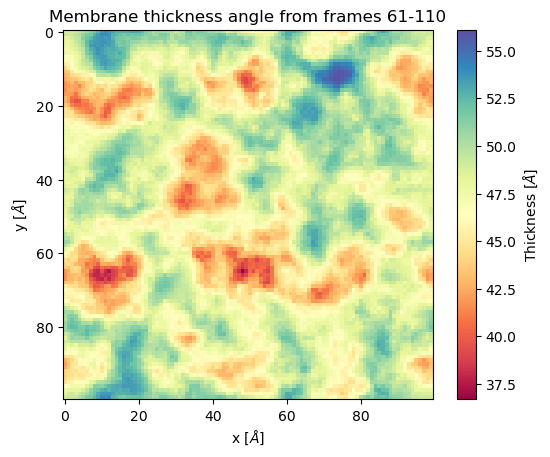

In [5]:

plt.imshow(thickness, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Membrane thickness angle from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('Thickness [$\AA$]')

Notice that the result is similar to what is obtained with Cuulative2D.

### Height

In a similar way, we can compute the height from the middle of the membrane for each layer as follows. These matrices are the ones used to generate the thickness. In the figure below you can find a plot for the top layer, the bottom layer and the comparison with the thickness.

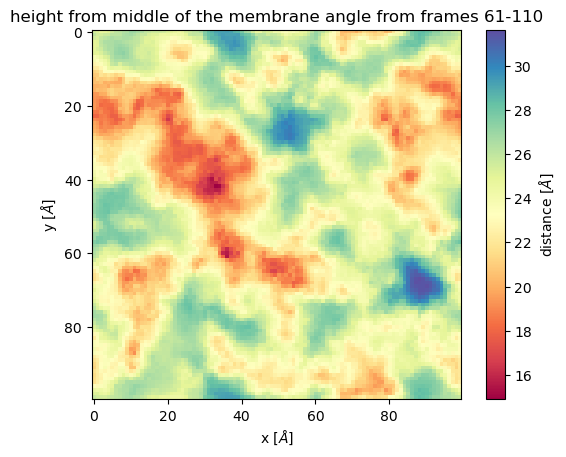

In [36]:
# Data for RNA membrane
traj = "membrane.xtc"
tpr = "../data/veamos.tpr"

universe = mda.Universe(tpr,traj)

membrane = Voronoi2D(universe, nbins=100)
lipid_list = list(membrane.lipid_list)
height, edges = membrane.voronoi_height(start=61,final = 110, step = 1, lipid_list=lipid_list, layer = "top")


plt.imshow(height, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("height from middle of the membrane angle from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('distance [$\AA$]')

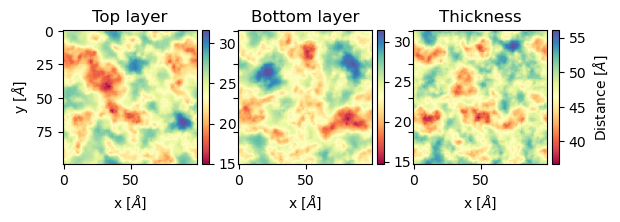

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

membrane = Voronoi2D(universe, nbins=100)
lipid_list = list(membrane.lipid_list)
height_top, edges = membrane.voronoi_height(start=61,final = 110, step = 1, lipid_list=lipid_list, layer = "top")
height_bot, edges = membrane.voronoi_height(start=61,final = 110, step = 1, lipid_list=lipid_list, layer = "bot")


matrices_to_plot = [height_top, height_bot, thickness]
names = ["Top layer", "Bottom layer", "Thickness" ]

# Plot the resulting thickness
fig, ax = plt.subplots(1,len(matrices_to_plot), sharex = True, sharey = True)

for i, matrix in enumerate(matrices_to_plot):
    first = ax[i].imshow(matrix, extent=edges, cmap="Spectral")
    ax[i].set_xlabel("x $[\AA]$")

    ax[i].set_title(names[i])

    divider1 = make_axes_locatable(ax[i])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(first, cax = cax1)
ax[0].set_ylabel("y $[\AA]$")
cbar.set_label('Distance $[\AA]$')



### Area per Lipid
Area per lipid is a parameter that indicates how packed are the lipids in the membrane, and it changes depending on the lipd composition, temperature or its interaction with a protein. It can also indicates different lipid phases such as gel phase or liquid disorcered phase. Furthermore, APL is known to be related with lateral pressure profiles and bending rigidity.

Changes in the APL are believed to influence curvature, and lipid rafts. 

Here, we present a software that can compute APL based on voronoi tessellations, but also map it to a 2D grid that can be used to take average over frames. This averages allow us to identify regions where the APL keep high or low accross the time.

Follows an example of APL computation for a membrane with 4 lipids:


In [38]:
# Define a Voronoi2D element
import MDAnalysis as mda

traj = "membrane.xtc"
tpr = "../data/veamos.tpr"
universe = mda.Universe(tpr,traj)
membrane = Voronoi2D(universe=universe)





# Run APL for a single frame
lipid_list = list(membrane.lipid_list)
voronoi_dict = membrane.voronoi_properties(layer = "top",
                                    lipid_list=lipid_list)
print(voronoi_dict["apl"])
print(lipid_list)
if "CHL1" in lipid_list:
    lipid_list.remove("CHL1")
lipid_list.remove("POPE")
voronoi_dict = membrane.voronoi_properties(layer = "top",
                                    lipid_list=lipid_list)

# Information is stored in the dictionary with the key "apl"
print(voronoi_dict["apl"])

{'POPE': 43.63621471731424, 'DSPC': 48.4981551937266, 'DODMA': 42.19540886506484, 'CHL1': 32.579571605561696}
['POPE', 'DSPC', 'DODMA', 'CHL1']
{'DSPC': 74.92449671542111, 'DODMA': 63.67213260902004}


As we can have a value for each lipid, we can project this into the 2D grid using Voronoi as follows


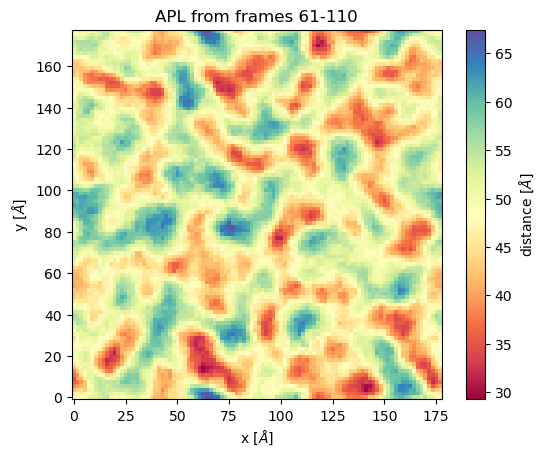

In [39]:
# Data for RNA membrane
import MDAnalysis as mda
from twodanalysis import Voronoi2D
import matplotlib.pyplot as plt
traj = "membrane.xtc"
tpr = "../data/veamos.tpr"

universe = mda.Universe(tpr,traj)

membrane = Voronoi2D(universe, nbins=100)
lipid_list = list(membrane.lipid_list)
apl, edges = membrane.voronoi_apl(start=61,final = 110, step = 1, lipid_list=lipid_list, layer = "top")


plt.imshow(apl, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("APL from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('distance [$\AA$]')

### Other properties

As mentioned before, Voronoi2D can be used to compute other properties than APL, thickness and height. For example here we show how to project splay angle and charge. 

Splay angle is already included in our package and can be used as follows:

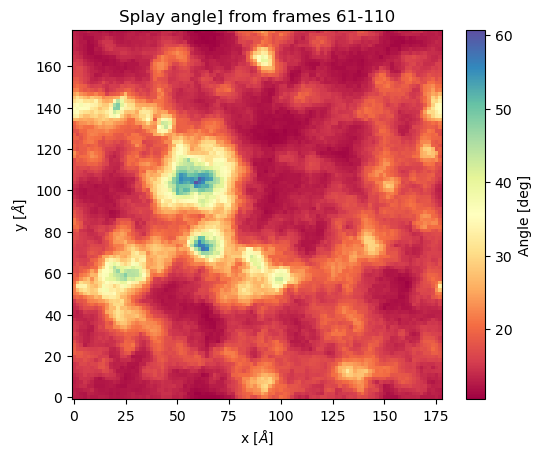

In [43]:
# Data for RNA membrane
traj = "membrane.xtc"
tpr = "../data/veamos.tpr"

universe = mda.Universe(tpr,traj)

membrane = Voronoi2D(universe, nbins=100)
lipid_list = list(membrane.lipid_list)
splay, edges = membrane.voronoi_splay(start=61,final = 110, step = 1, lipid_list=lipid_list, layer = "top")


plt.imshow(splay, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Splay angle] from frames 61-110")
cbar = plt.colorbar()
cbar.set_label('Angle [deg]')

Other properties such as charge can be also projected in the twod plane. Here we use an example charge map to show the versatility of our code.

In [1]:
from twodanalysis import Voronoi2D
import MDAnalysis as mda
import matplotlib.pyplot as plt
import numpy as np

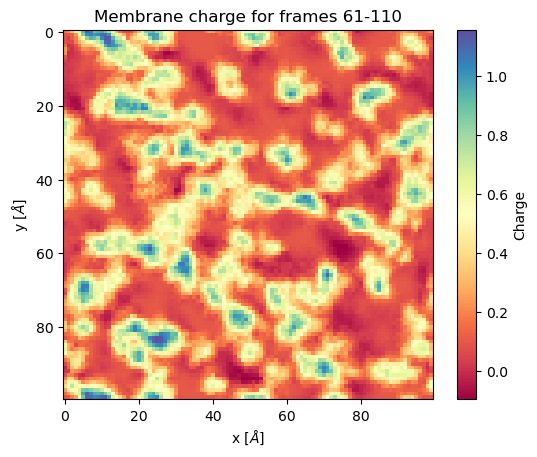

In [6]:
# Define functions to map charges

traj = "membrane.xtc"
tpr = "../data/veamos.tpr"

universe = mda.Universe(tpr,traj)
membrane = Voronoi2D(universe, nbins=100)
def map_charges(atomgroup):
    dict_charge = {
        "DODMA" : -0.1,
        "DSPC" : 0.1,
        "CHL1" : 0,
        "POPE" : 1.2,
    }
    ids = atomgroup.residues.resids

    charges = [dict_charge[lipid] for lipid in atomgroup.residues.resnames]    
    charges = np.array(charges)

    return ids, charges


# Project property

charges_m, edges = membrane.project_property(map_charges, layer = "top", start=61, final = 110)
plt.imshow(charges_m, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("Membrane charge for frames 61-110")
cbar = plt.colorbar()
cbar.set_label('Charge')

Also, if you want to see how individual lipids are distributed you may want to do a function that maps the desired lipid with 1 and the other with 0, as follows

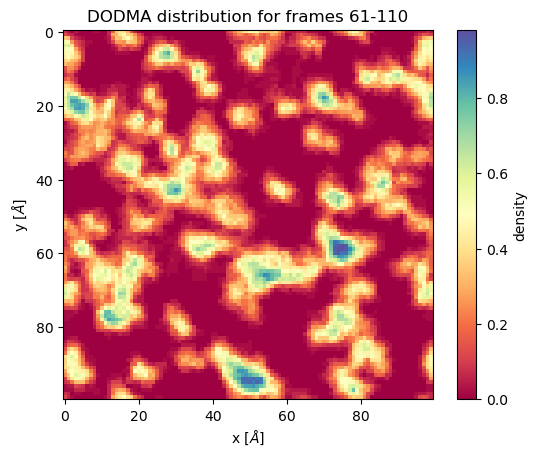

In [4]:
# Define functions to map charges

traj = "membrane.xtc"
tpr = "../data/veamos.tpr"

universe = mda.Universe(tpr,traj)
membrane = Voronoi2D(universe, nbins=100)
def map_distribution(atomgroup):
    dict_charge = {
        "DODMA" : 1,
        "DSPC" : 0,
        "CHL1" : 0,
        "POPE" : 0,
    }
    ids = atomgroup.residues.resids

    charges = [dict_charge[lipid] for lipid in atomgroup.residues.resnames]    
    charges = np.array(charges)

    return ids, charges


# Project property

charges_m, edges = membrane.project_property(map_distribution, layer = "top", start=61, final = 110)
plt.imshow(charges_m, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("DODMA distribution for frames 61-110")
cbar = plt.colorbar()
cbar.set_label('density')

You can only plot values different form zero as follows:

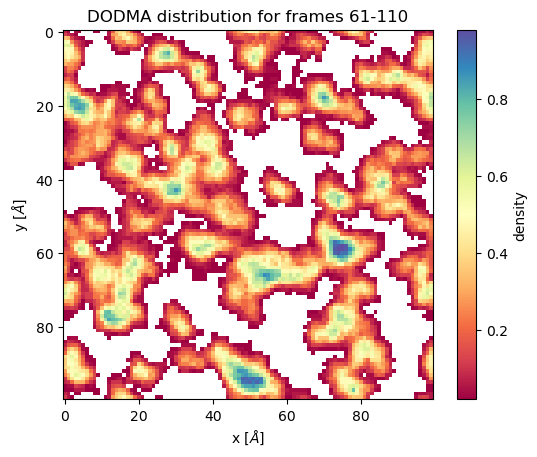

In [5]:
charges_m[charges_m == 0] = np.nan
plt.imshow(charges_m, extent=edges, cmap="Spectral")
plt.xlabel("x [$\AA$]")
plt.ylabel("y [$\AA$]")
plt.title("DODMA distribution for frames 61-110")
cbar = plt.colorbar()
cbar.set_label('density')

Regions with blue show a preference for DODMA lipid or that the region has been preferently populated by DODMA lipids.

The approach used also affects the meaning of the values in the plot, remember that Voronoi2D uses projections each frame and then average over frames. This, regions with 1 or close to 1 have been almost exclusively populated by DODMA.